# Affinity & Solubility prediction modeling using ChemBL database: A Machine-learning based approach (Solubility Prediction Modeling) 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.externals.six import StringIO 
#import pydotplus
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from IPython.display import Image  
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

/home/shyam_gsdk/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


1. Read solubility data

In [2]:
data=pd.read_csv('Combined_data_with_FP_solubility_modeling.csv')

2. Splitting data for training and testing

In [4]:
filtered_data=data.dropna(subset=['acd_logp'])
SolubilityModelData=pd.concat([filtered_data.filter(like='fp'),filtered_data['acd_logp']],axis=1)
train_data, test_data = train_test_split(SolubilityModelData, test_size=0.2)

In [5]:
(nr_train,nc_train)=train_data.shape
print (train_data.shape)
(nr_test,nc_test)=test_data.shape
X_train=train_data.iloc[:,1:nc_train-1]
y_train=train_data["acd_logp"]
X_test=test_data.iloc[:,1:nc_test-1]
y_test=test_data["acd_logp"]

(11966, 1025)


3. Dimensionality Reduction using PCA and SVD

In [24]:
# Principal component analysis
ncomps=[50,100,500,800,1000]
var_pca=list()
for ncomp in ncomps:
    pca=PCA(n_components=ncomp)
    scaler=StandardScaler()
    PCAModel= make_pipeline(scaler,pca)
    PCAModel.fit(X_train)
    print(sum(PCAModel.named_steps['pca'].explained_variance_ratio_))
    var_pca.append(sum(PCAModel.named_steps['pca'].explained_variance_ratio_))
Xpcatrain=PCAModel.transform(X_train)
Xpcatest=PCAModel.transform(X_test)

# 800 components were used to capture 95% variance

0.9517781825270165


In [82]:
# Truncated SVD Method
svd=TruncatedSVD(n_components=800)
svd.fit(X_train)
Xsvdtrain=svd.transform(X_train)
Xsvdtest=svd.transform(X_test)
print (sum(svd.explained_variance_ratio_))
var_svd=sum(svd.explained_variance_ratio_)

0.9562158998196905


4. Regression Tree for solubility prediction modeling

In [35]:
# Training on original data
Xtrain=X_train
ytrain=y_train
Xtest=X_test
ytest=y_test
parameters={'max_depth':[75,100,450]}
regtree=DecisionTreeRegressor()
regtree=GridSearchCV(cv=5,estimator=regtree,param_grid=parameters,refit=True,n_jobs=-1)
regtree.fit(Xtrain,ytrain)
ytrainfit=regtree.predict(Xtrain)
ypredtest=regtree.predict(Xtest)

trainR2=regtree.score(Xtrain,ytrain)
testR2=regtree.score(Xtest,ytest)

print ("Training R2=",trainR2," Test R2=",testR2)
best_tree_model=regtree.best_estimator_
best_score=regtree.best_score_
print (best_tree_model)
print (best_score)

"""
Best Model:
Training R2= 0.999582351276179  Test R2= 0.6496148320477937
DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
CV R2= 0.5901977319652961

"""



Training R2= 0.999582351276179  Test R2= 0.6496148320477937
DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
0.5901977319652961


In [ ]:
# Train Regression Tree on SVD scores
Xtrain=Xsvdtrain
ytrain=y_train
Xtest=Xsvdtest
ytest=y_test
parameters={'max_depth':[25,50,100,150,200,300]}
regtree=DecisionTreeRegressor()
regtree=GridSearchCV(cv=5,estimator=regtree,param_grid=parameters,refit=True,n_jobs=-1)
regtree.fit(Xtrain,ytrain)
ytrainfit=regtree.predict(Xsvdtrain)
ypredtest=regtree.predict(Xsvdtest)

trainR2=regtree.score(Xsvdtrain,ytrain)
testR2=regtree.score(Xsvdtest,ytest)

print ("Training R2=",trainR2," Test R2=",testR2)
best_tree_model=regtree.best_estimator_
print (best_tree_model)
best_cv_score=regtree.best_score_
print (best_cv_score)

"""
Best model:
Training R2= 0.999582351276179  Test R2= 0.5768005253013688
DecisionTreeRegressor(criterion='mse', max_depth=200, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Best_cv_score=0.517
"""

5. XGBoost Regression for solubility modeling

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
Xtrain=X_train
ytrain=y_train
Xtest=X_test
ytest=y_test
parameters={'max_depth':[10,50,100,150],'n_estimators':[10,50,100,150]}
xgboost=GradientBoostingRegressor()
xgboostMdl=GridSearchCV(cv=5,estimator=xgboost,param_grid=parameters,refit=True,n_jobs=-1)
xgboostMdl.fit(Xtrain,ytrain)
ytrainfit=xgboostMdl.predict(Xtrain)
ypredtest=xgboostMdl.predict(Xtest)

trainR2_xg=xgboostMdl.score(Xtrain,ytrain)
testR2_xg=xgboostMdl.score(Xtest,ytest)

print ("Training R2=",trainR2_xg," Test R2=",testR2_xg)
best_xgboost_Mdl=xgboostMdl.best_estimator_
print (best_xgboost_Mdl)
best_cv_score_xg=xgboostMdl.best_score_

"""
parameters={'max_depth':[10,50,100,150],'n_estimators':[10,50,100,150]}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Training R2= 0.9973967230196311  Test R2= 0.8665960867663121 CV R2=0.832001444085638

"""


In [97]:
print (best_xgboost_Mdl)
print ("Training R2=",trainR2_xg," Test R2=",testR2_xg)
print (best_cv_score_xg)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Training R2= 0.9973967230196311  Test R2= 0.8665960867663121
0.832001444085638


6. Random Forest Regression for solubility modeling

In [ ]:
Xtrain=X_train
ytrain=y_train
Xtest=X_test
ytest=y_test
parameters={'max_depth':[10,50,100,150],'n_estimators':[10,50,100,150]}
RF=RandomForestRegressor()
RFMdl=GridSearchCV(cv=5,estimator=RF,param_grid=parameters,refit=True,n_jobs=-1)
RFMdl.fit(Xtrain,ytrain)
ytrainfit=RFMdl.predict(Xtrain)
ypredtest=RFMdl.predict(Xtest)

trainR2_rf=RFMdl.score(Xtrain,ytrain)
testR2_rf=RFMdl.score(Xtest,ytest)

print ("Training R2=",trainR2_rf," Test R2=",testR2_rf)
best_RF_Mdl=RFMdl.best_estimator_
print (best_RF_Mdl)
best_cv_score_RF=RFMdl.best_score_

"""
Best Model:
parameters={'max_depth':[10,50,100,150],'n_estimators':[10,50,100,150]}
parameters={'max_depth':[30,60,100],'n_estimators':[10,50,100]}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Training R2= 0.9755016998816263 Test R2= 0.8393336180564913 CV R2=0.8041421233391818
"""



7. Neural network regression using tensorflow

In [85]:
def build_model(nlayer,n,input_size):
    model=keras.Sequential()
    model.add(layers.Dense(n[0],input_shape=(input_size,),kernel_initializer='glorot_uniform'))
    for k in range(nlayer):
        model.add(layers.Dense(n[k],activation='relu',kernel_initializer='glorot_uniform'))
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation='linear'))
    
    opt=tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=opt)
    
    return model

In [89]:
tf.keras.backend.clear_session()
#Xtrain=X_train.values
Xtrain=Xsvdtrain 
#Xtest=X_test.values
Xtest=Xsvdtest
ytest=y_test.values
ytrain=y_train.values
nlayer=5
n_neurons=200*np.ones(shape=(nlayer,1))
eps=0.001
n_epoch=300
n_batch=100
checkpoint_path = "training_1/cp.ckpt"

TFmodel=build_model(nlayer,n_neurons,Xtrain.shape[1])
stop_call = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',min_delta=0.000001,patience=50,verbose=1,restore_best_weights=True)
check_pt = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,save_weights_only=True,verbose=0)
modelfit=TFmodel.fit(Xtrain,ytrain,epochs=n_epoch, batch_size=n_batch, validation_split = 0.2, verbose=2,callbacks=[stop_call,check_pt])

# Best DL Model: Original X, dropout=0.2,n_epoch=300,batchsize=100, patience=50,layer=5,neuron per layer=256,R2 (train)=96, R2(test)=87

Train on 9572 samples, validate on 2394 samples
Epoch 1/300
9572/9572 - 2s - loss: 6.0308 - val_loss: 4.5118
Epoch 2/300
9572/9572 - 1s - loss: 2.9310 - val_loss: 2.8738
Epoch 3/300
9572/9572 - 1s - loss: 1.8244 - val_loss: 2.5651
Epoch 4/300
9572/9572 - 1s - loss: 1.3737 - val_loss: 2.6595
Epoch 5/300
9572/9572 - 1s - loss: 1.2607 - val_loss: 2.1216
Epoch 6/300
9572/9572 - 1s - loss: 1.0692 - val_loss: 3.5398
Epoch 7/300
9572/9572 - 1s - loss: 0.9678 - val_loss: 2.1504
Epoch 8/300
9572/9572 - 1s - loss: 0.8531 - val_loss: 3.2513
Epoch 9/300
9572/9572 - 1s - loss: 0.8439 - val_loss: 2.5072
Epoch 10/300
9572/9572 - 1s - loss: 0.7546 - val_loss: 2.7429
Epoch 11/300
9572/9572 - 1s - loss: 0.7182 - val_loss: 2.1421
Epoch 12/300
9572/9572 - 1s - loss: 0.6843 - val_loss: 2.5040
Epoch 13/300
9572/9572 - 1s - loss: 0.6783 - val_loss: 2.2926
Epoch 14/300
9572/9572 - 1s - loss: 0.6399 - val_loss: 2.6439
Epoch 15/300
9572/9572 - 1s - loss: 0.6649 - val_loss: 2.1540
Epoch 16/300
9572/9572 - 1s - l

Training R2= 0.9513011118627407  Test R2= 0.8629978426041548


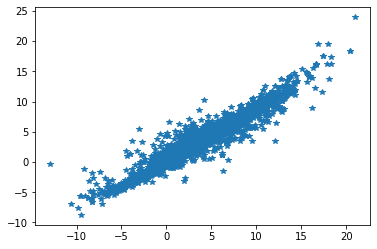

In [90]:
ypred_test = TFmodel.predict(Xtest)
ypred_train=TFmodel.predict(Xtrain)
R2_TF_test= r2_score(ytest, ypred_test)
R2_TF_training=r2_score(ytrain,ypred_train)
print ("Training R2=",R2_TF_training," Test R2=",R2_TF_test)
plt.plot(ytrain,ypred_train,'*')